In [187]:
import os
import sys
import time
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [188]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

In [189]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [190]:
path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L"

In [191]:
paths = {}
for folder in os.walk(path):
    key = folder[0].split(os.path.sep)[-1]
    li = []
    for file in folder[2:][0]:
        if file.split('.')[-1] == "bdf":
            li.append(os.path.join(folder[0], file))
    if len(li) > 0:
        paths[key] = li

In [192]:
for key, value in paths.items():
    print(key)

RecV3_2_ang+
RecV3_3_ang+
RecV3_4_ang+
RecV3_1_ang-


In [143]:
min_per_epoch = 10
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]]) 
chans = ["Channel 1", "Channel 2"]
kinds = ["Power", 
         "Power {}-{}".format(bands[0,0], bands[0,1]), 
         "Power {}-{}".format(bands[1,0], bands[1,1]),
         "Speed"
        ]

data = []
for chan in chans:
    for kind in kinds:
        data.append("{} {}".format(chan, kind))        
data.append("Subject")
data.append("Record")

data = pd.DataFrame(columns=data)

start_epoc = 0
counter = 0


for key, value in paths.items():
    for name in value:

        # read EEG and acceleration data
        raw_data = mne.io.read_raw_edf(name)
        fs = round(raw_data.info['sfreq'])
        df = pd.DataFrame(raw_data.get_data().T, columns=raw_data.info["ch_names"])        

        # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
        n_epocs = int(np.floor(df.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
        n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Skip damaged samples at the ending
        df_epocs = df.iloc[:n_samples, :]

        # Polygraphy epoch length in EEG samples.
        step = fs*SEC_PER_MIN*min_per_epoch

        data_new = {}
        
        for chan in chans:

            b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_low = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter

            b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])
            
            data_new.update({
                "{} {}".format(chan, kinds[0]): np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[1]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[2]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[3]): np.array(list(map(lambda i: (np.abs(df_epocs.iloc[i*step:(i+1)*step, 1]-df_epocs.iloc[i*step:(i+1)*step, 1].mean())).mean(), np.arange(n_epocs)))),
            })

        data_new = pd.DataFrame(data_new)
        data_new["Subject"] = key
        data_new["Record"] = counter
        
        data = pd.concat([data, data_new])
        
        start_epoc += n_epocs
        counter += 1
        
        data

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/01-02-2019_14-22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: F

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/31-01-2019_15-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/01-02-2019_14-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/31-01-2019_15-28.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/01-02-2019_14-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/31-01-2019_15-43.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/31-01-2019_15-23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-143-1a42c9b2441a>:29: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


In [118]:
data0 = pd.DataFrame(np.random.randn(100, 3), columns=["A", "B", "C"])

In [119]:
data1 = pd.DataFrame(np.random.randn(100, 3), columns=["A", "B", "C"])

In [121]:
pd.concat([data0, data1]).shape

(200, 3)

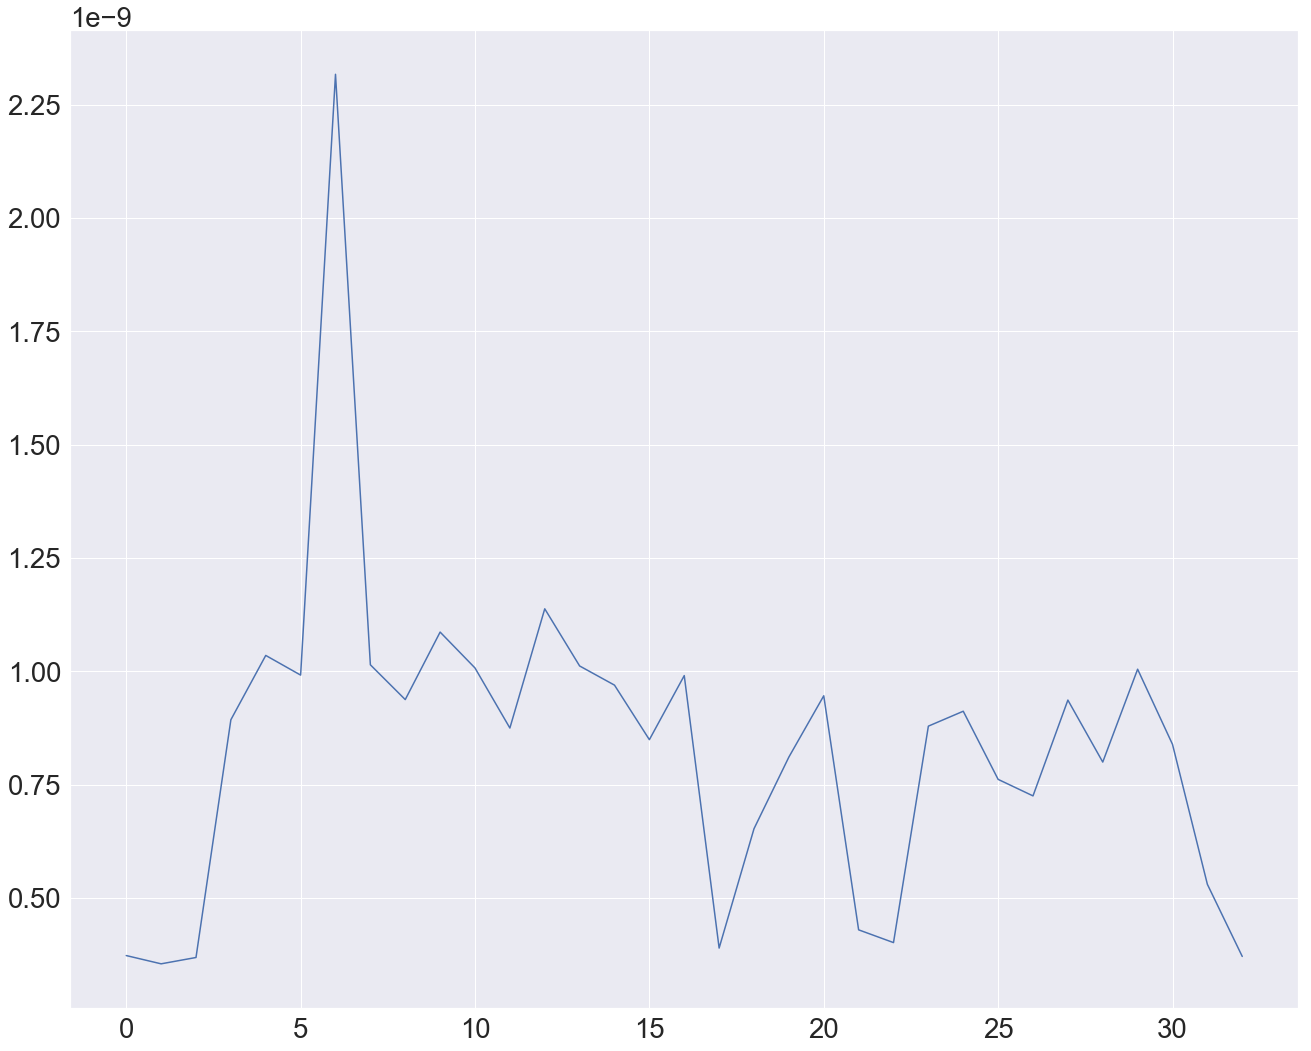

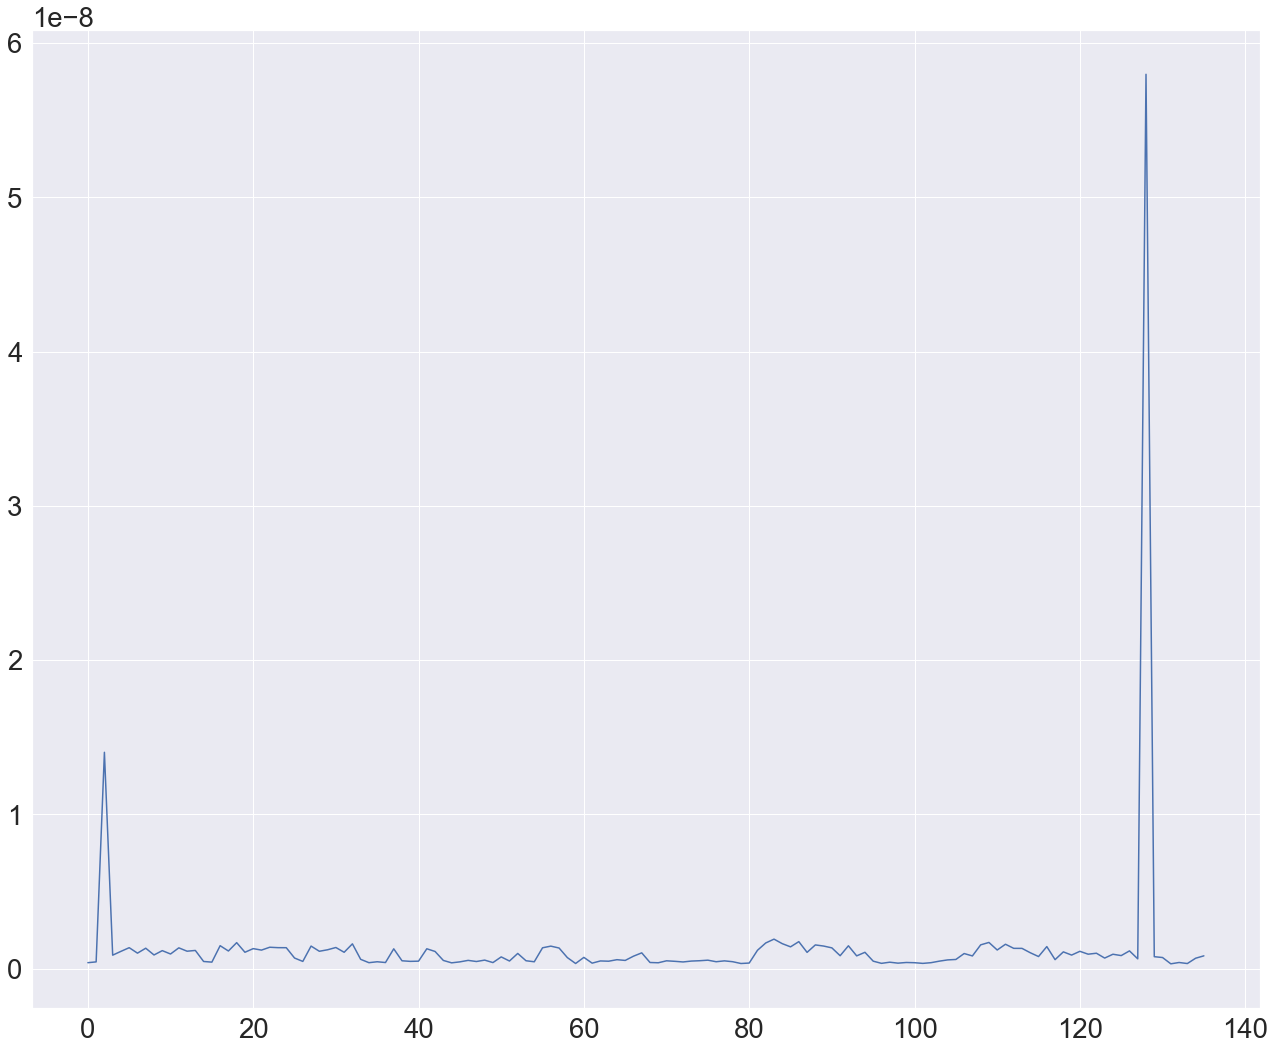

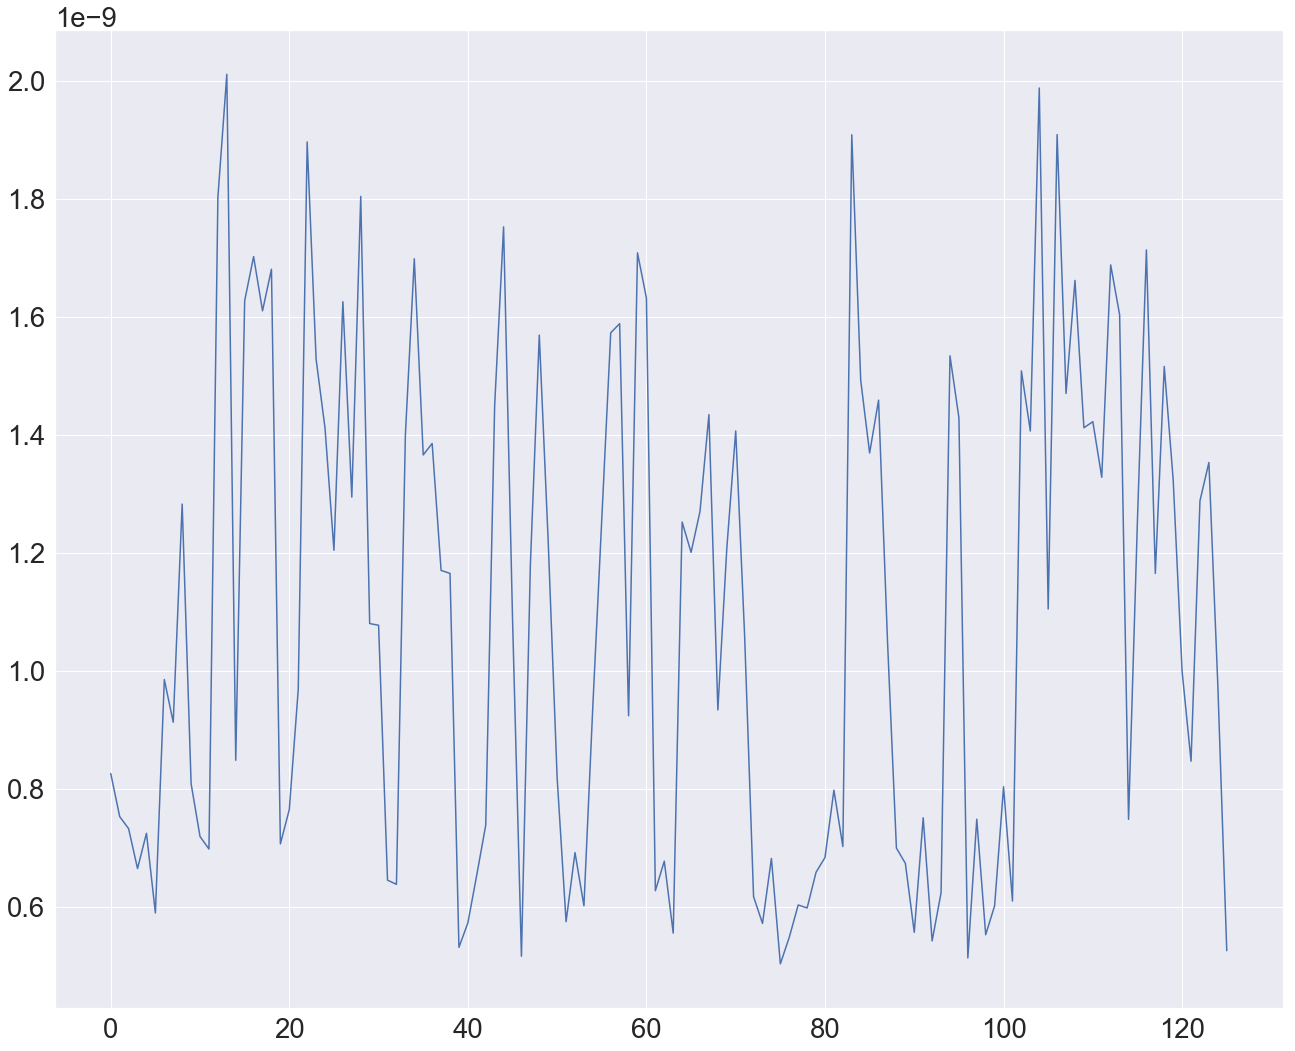

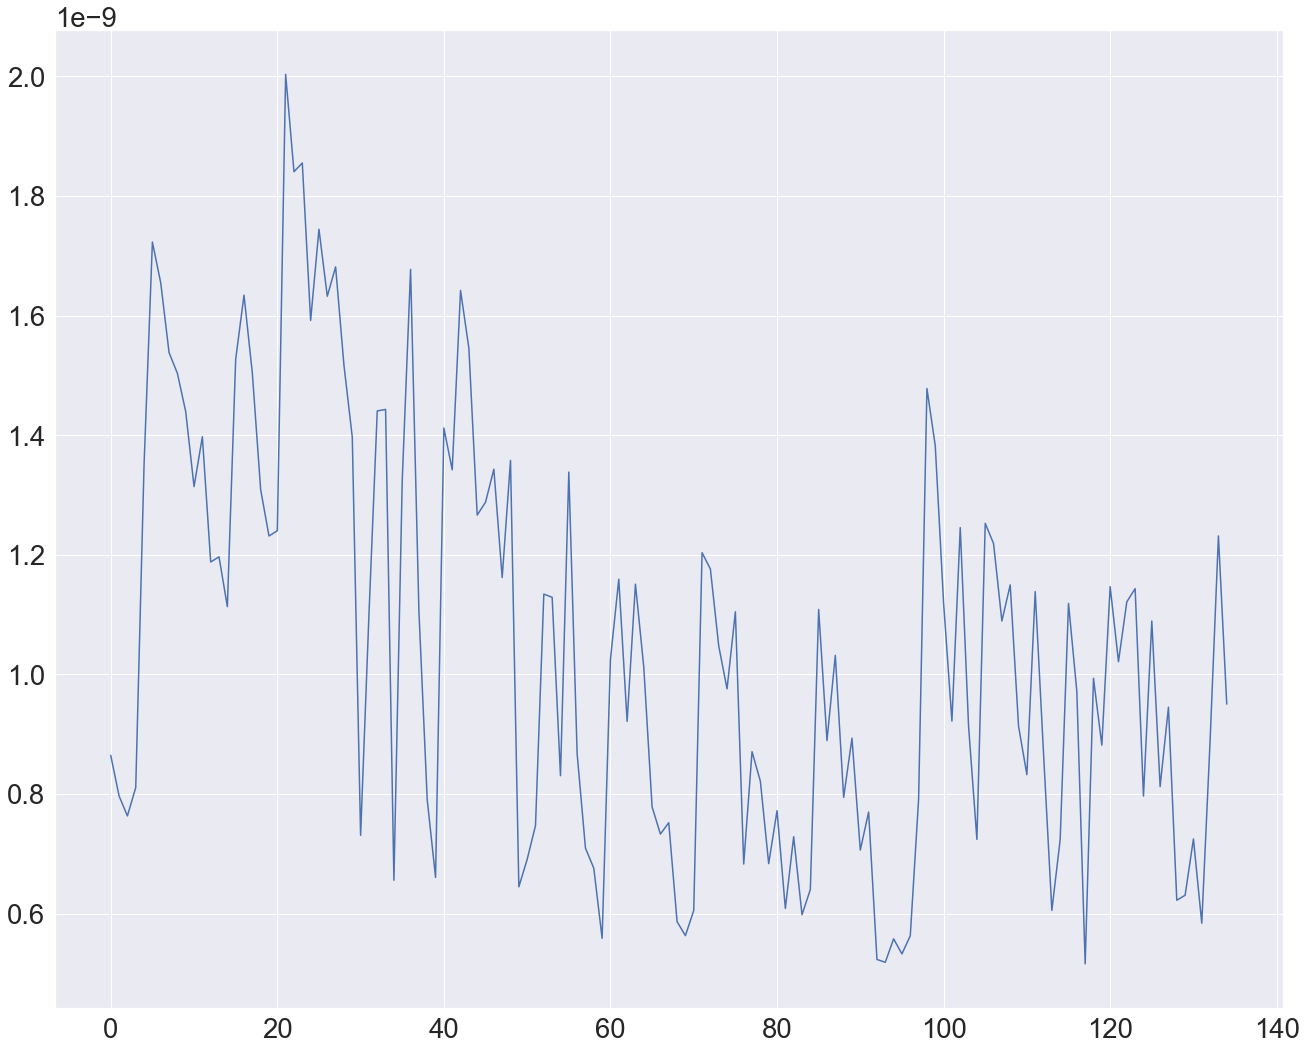

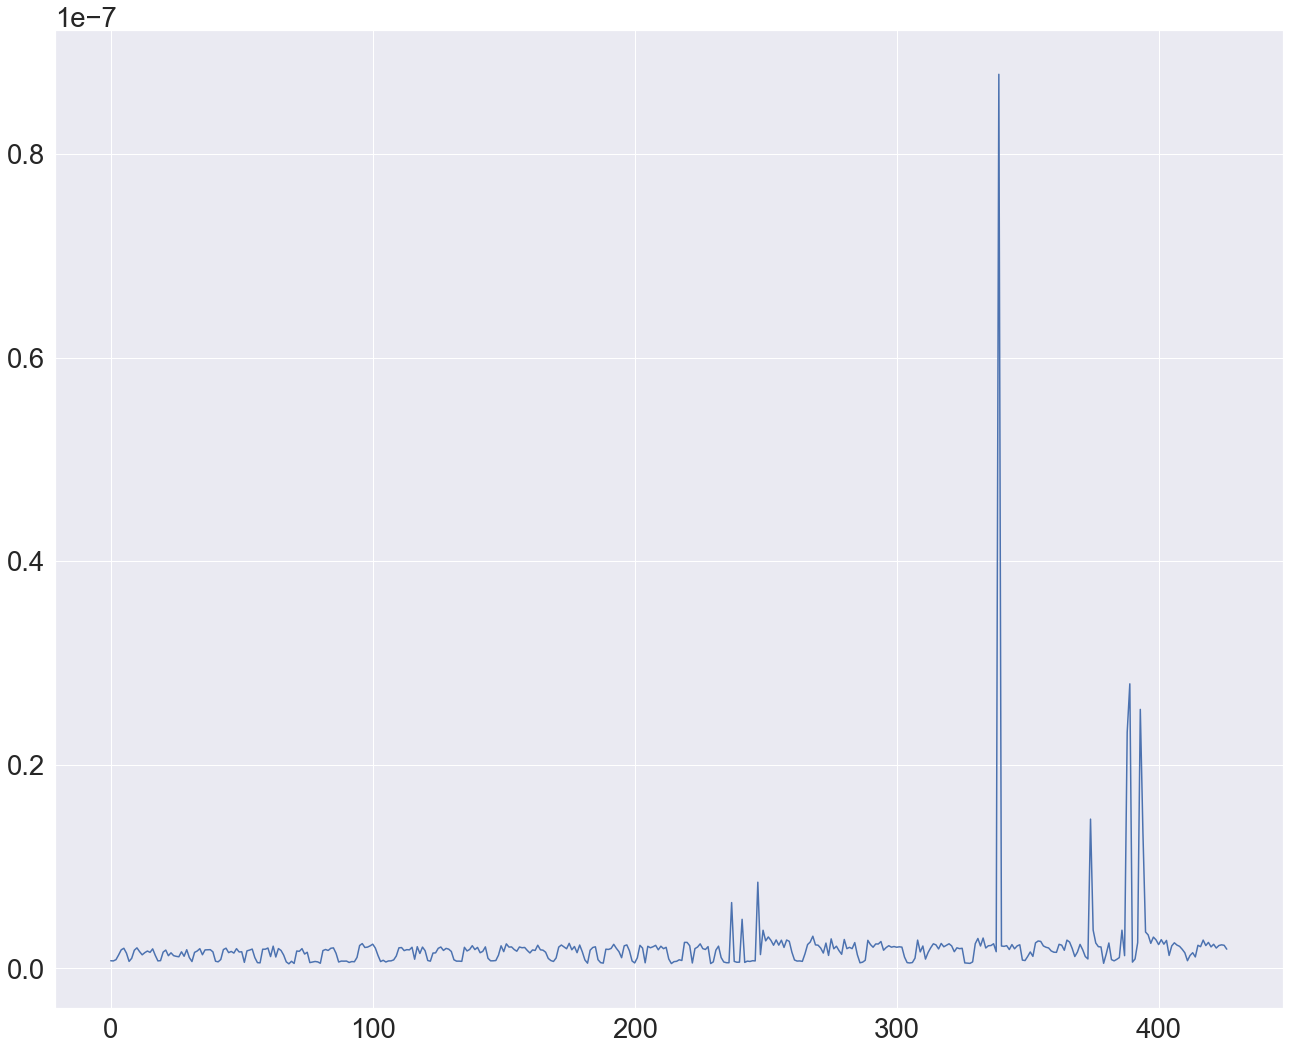

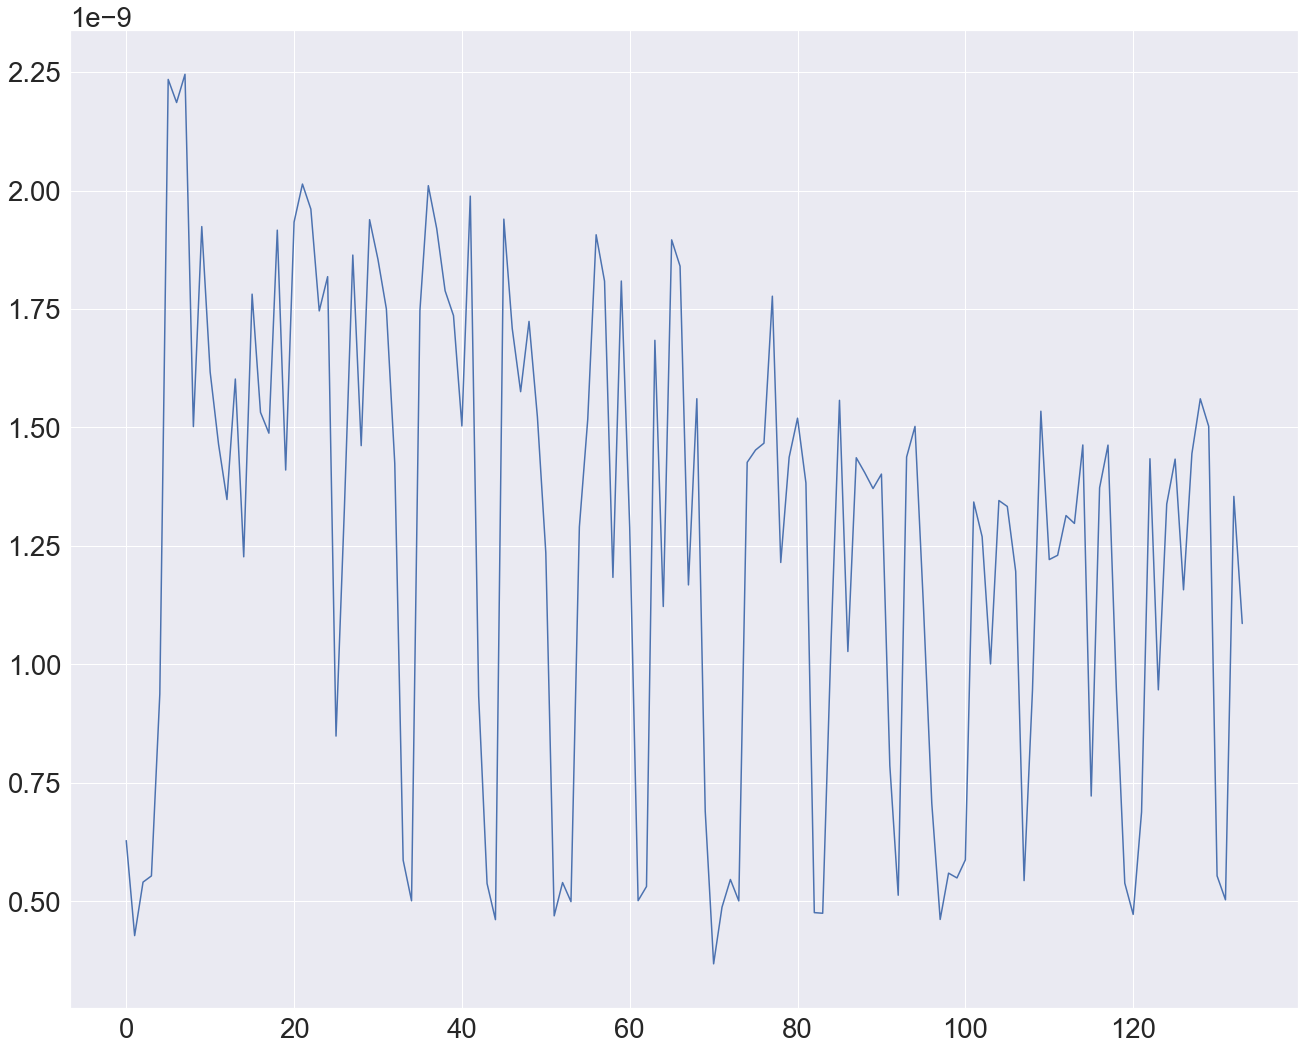

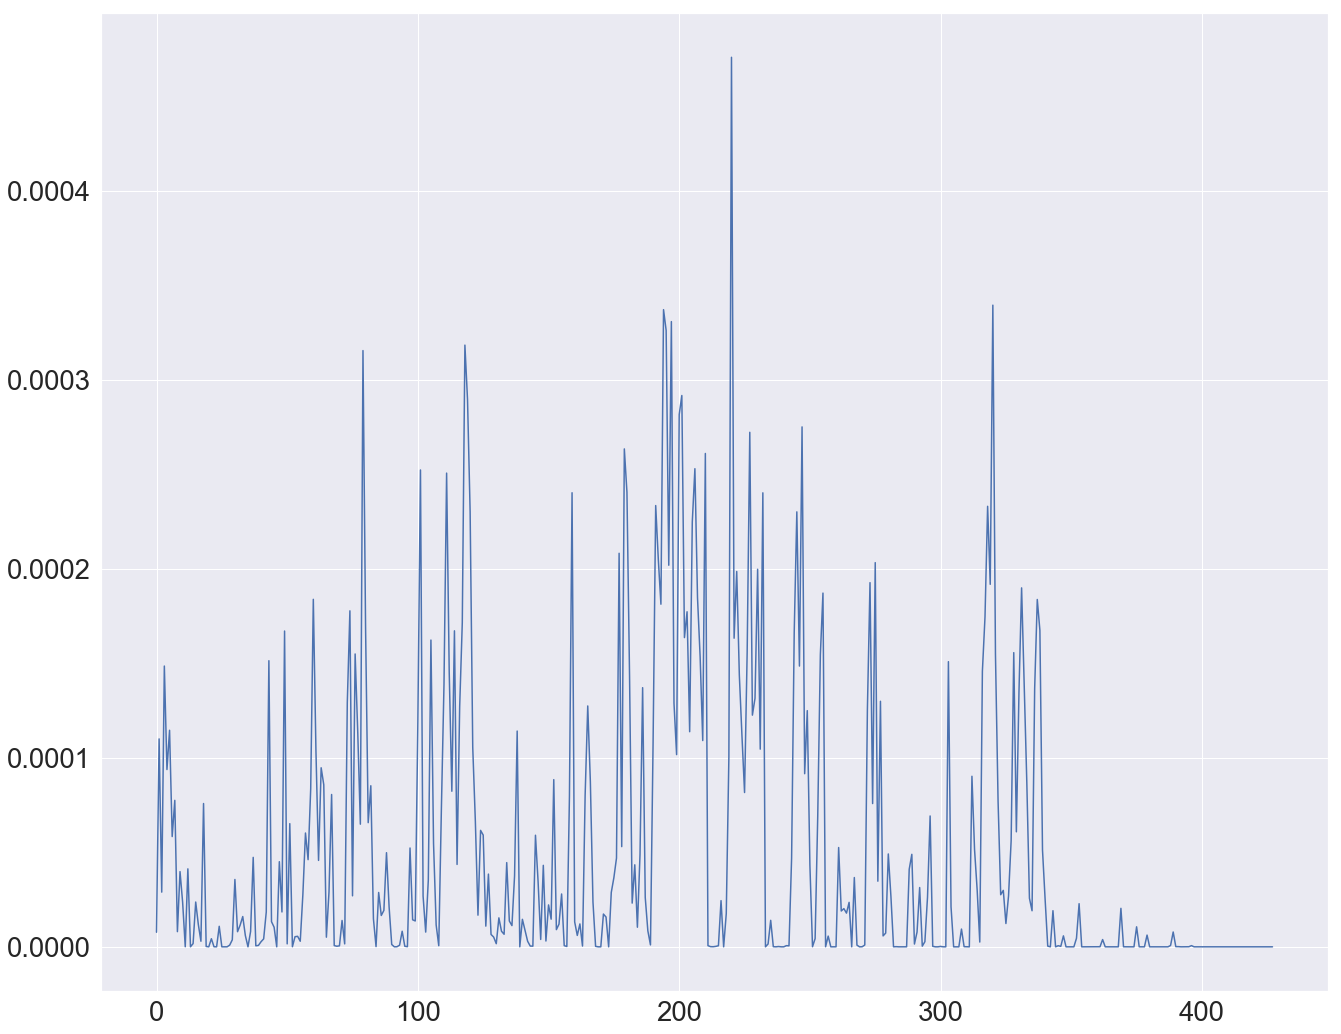

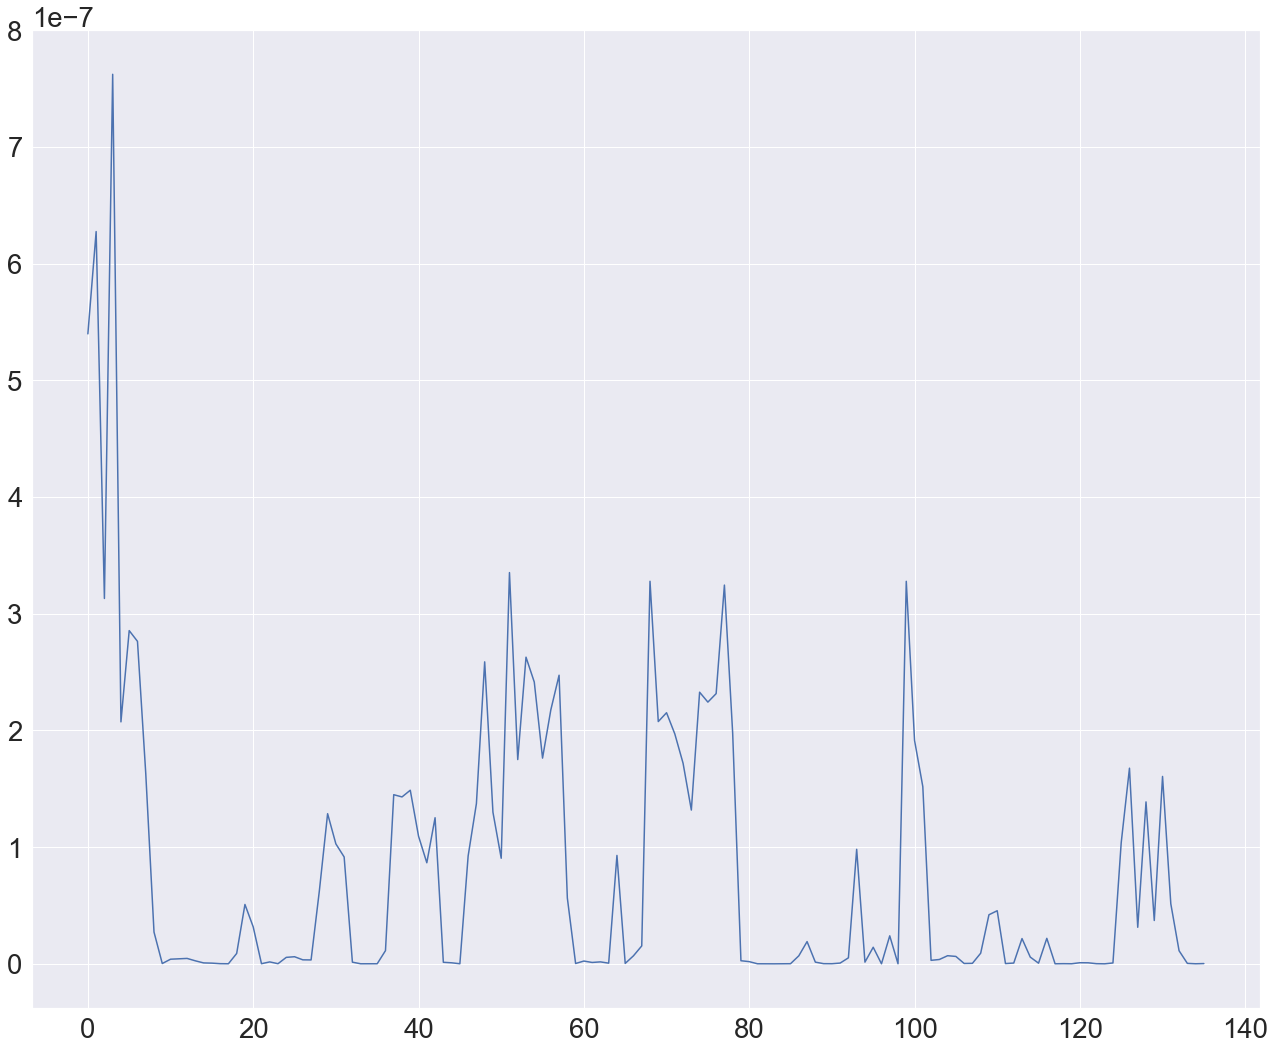

In [204]:
for i in np.arange(8):
    plot(data[data["Record"] == i]["Channel 1 Power 4-8"])
    show()

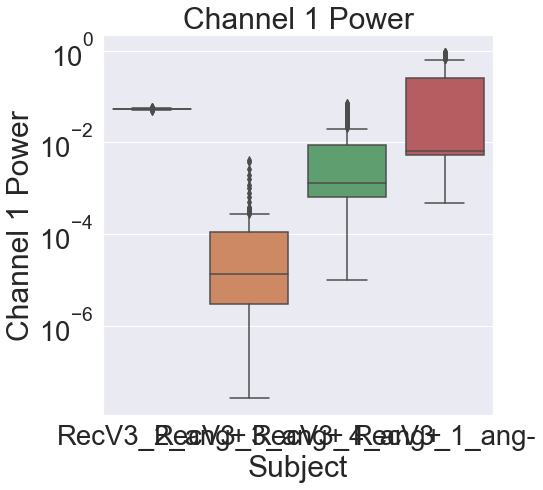

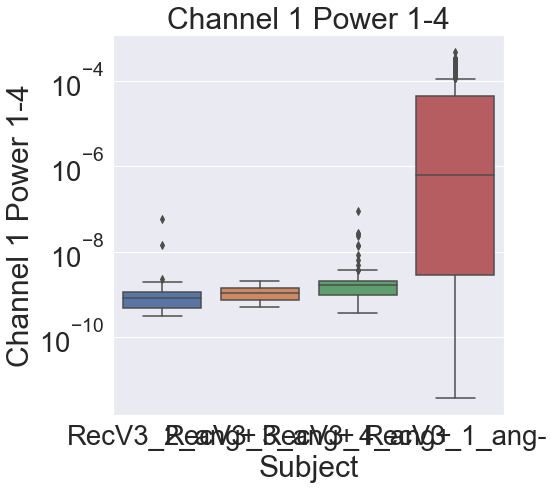

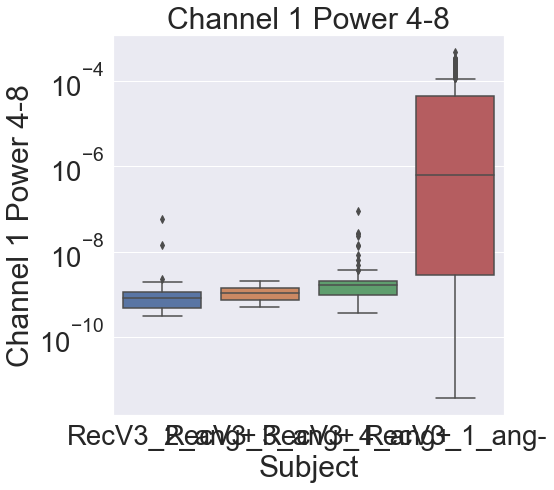

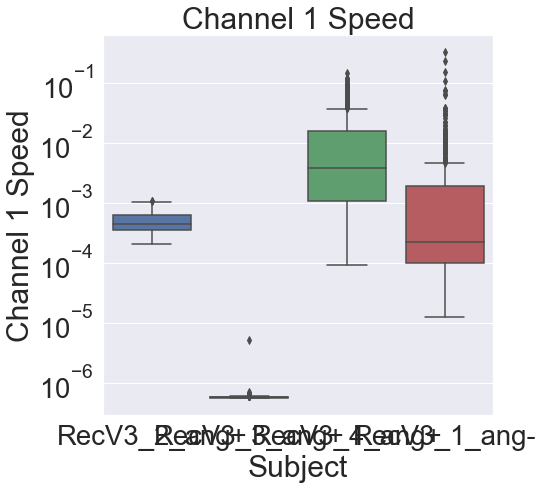

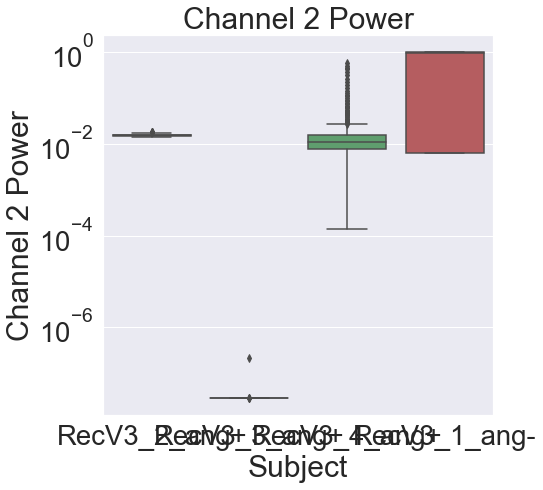

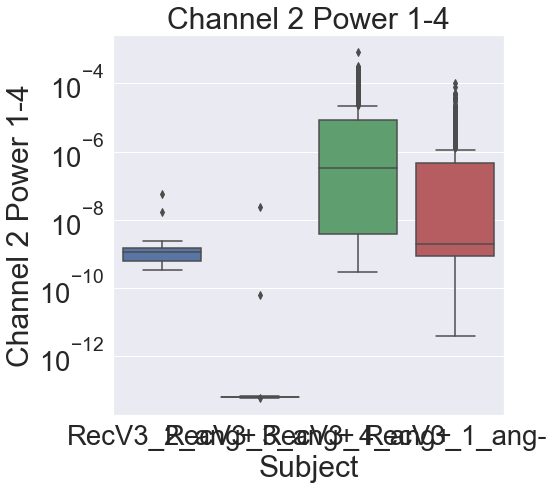

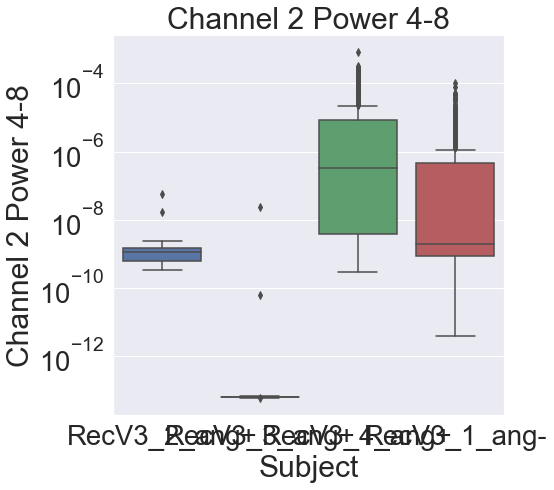

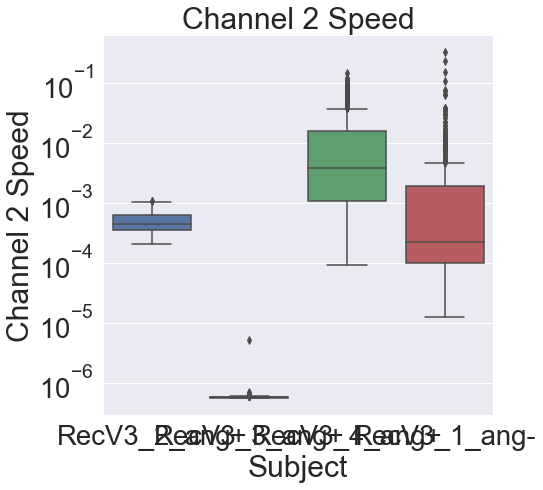

ValueError: Neither the `x` nor `y` variable appears to be numeric.

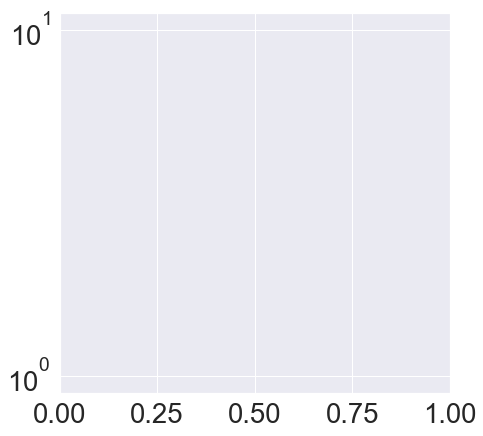

In [200]:
for name in data.columns:

    f, ax = plt.subplots(figsize=(7, 7))
    ax.set(yscale="log")
    sns.boxplot(x="Subject", y=name, data=data, ax=ax)
    title(name)

    #     subplot(1,2,1)
    #     hist(data[data["Subject"] == key]["Channel 1 Power 4-8"])
    # title(key)
    #     xlim([0, 1e-3])
    #     subplot(1,2,2)
    #     hist(data[data["Subject"] == key]["Channel 1 Speed"])
    #     xlim([0, 0.1])
    show()

In [199]:
data.columns

Index(['Channel 1 Power', 'Channel 1 Power 1-4', 'Channel 1 Power 4-8',
       'Channel 1 Speed', 'Channel 2 Power', 'Channel 2 Power 1-4',
       'Channel 2 Power 4-8', 'Channel 2 Speed', 'Subject', 'Record'],
      dtype='object')